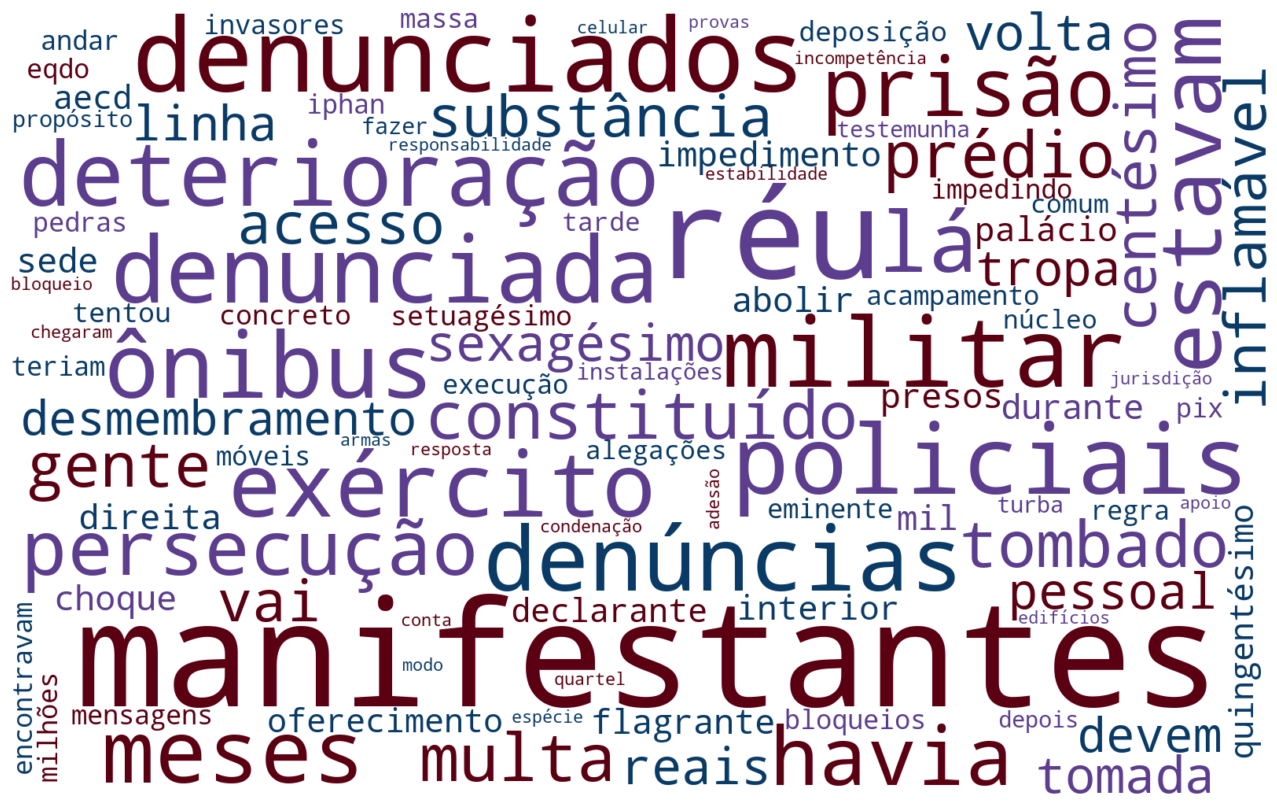

In [1]:
from pathlib import Path
import json
import re
import random
from collections import Counter

import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

try:
    import spacy
    try:
        nlp = spacy.load("pt_core_news_lg")
    except OSError:
        try:
            nlp = spacy.load("pt_core_news_md")
        except OSError:
            try:
                nlp = spacy.load("pt_core_news_sm")
            except OSError:
                nlp = None
except ImportError:
    nlp = None

try:
    from unidecode import unidecode
    HAS_UNIDECODE = True
except ImportError:
    HAS_UNIDECODE = False

config_path = (
    Path.home()
    / "Documents"
    / "jurimetria_aved_stf"
    / "config"
    / "project_config.json"
)
config = json.loads(config_path.read_text(encoding="utf-8"))

thematic_dir = Path(config["paths"]["thematic_dir"]).expanduser()
master_dir   = Path(config["paths"]["master_dir"]).expanduser()
figures_dir  = Path(config["paths"]["figures_dir"]).expanduser()
logs_dir     = Path(config["paths"]["logs_dir"]).expanduser()
pdf_txt_dir  = Path(config["paths"]["pdf_txt_dir"]).expanduser()

thematic_dir.mkdir(parents=True, exist_ok=True)
master_dir.mkdir(parents=True, exist_ok=True)
figures_dir.mkdir(parents=True, exist_ok=True)
logs_dir.mkdir(parents=True, exist_ok=True)

sample_texts_dir = master_dir / "sample_texts"

texts = []
used_source = None

sample_csv = master_dir / "thematic_sample.csv"
if sample_csv.exists():
    df_sample = pd.read_csv(sample_csv)
    for row in df_sample.itertuples():
        fname = row.file_name
        src1 = sample_texts_dir / fname
        src2 = thematic_dir / fname
        if src1.exists():
            texts.append(src1.read_text(encoding="utf-8", errors="ignore"))
            used_source = "sample_texts"
        elif src2.exists():
            texts.append(src2.read_text(encoding="utf-8", errors="ignore"))
            used_source = "thematic_fallback"

if not texts:
    thematic_files = sorted(thematic_dir.glob("*.txt"))
    for p in thematic_files:
        texts.append(p.read_text(encoding="utf-8", errors="ignore"))
    used_source = used_source or "all_thematic"

if not texts:
    texts = ["sem dados para análise"]
    used_source = "empty"

proj_stop = set()
tp_conf = config.get("text_processing", {})
if tp_conf and tp_conf.get("stopwords"):
    for sw in tp_conf["stopwords"]:
        sw_low = sw.lower()
        proj_stop.add(sw_low)
        if HAS_UNIDECODE:
            proj_stop.add(unidecode(sw_low))

base_stop = {
    "o","a","os","as","de","da","do","das","dos","em","no","na","nos","nas",
    "para","por","com","ao","aos","à","às","um","uma","uns","umas",
    "que","se","seu","sua","seus","suas","é","era","foi","são","ser","há","houve",
    "como","mais","menos","também","muito","muitos","muita","muitas","pouco","poucos",
    "sobre","entre","até","após","antes","e","ou","mas","porque","pois","quando","onde",
    "qual","quais","cujo","cuja","cujos","cujas",
    "art","inc","§","§§","fig","fls","fl","doc","docs",
    "ementa","acordao","acórdão","relatorio","relatório","voto","decisao","decisão",
    "processo","autos","classe","distribuicao","distribuição",
    "sessao","sessão","plenaria","plenária","publicacao","publicação","dje","djou","djul",
    "brasilia","brasília","df",
    "procurador","procuradora","procuradoria","representante",
    "presidente","vice","despacho",
    "supremo","tribunal","federal","stf","supremo_tribunal_federal",
    "um","uma","dois","duas","tres","três","quatro","cinco","seis",
    "sete","oito","nove","dez",
    "primeiro","primeira","segundo","segunda","terceiro","terceira","quarto","quarta",
    "quinto","quinta","sexto","sexta","setimo","setima","oitavo","oitava",
    "nono","nona","decimo","decima",
    "ai","aí","me","pra","es","né","voce","você",
    "tudo","data","entao","então",
    "eu","meu",
    "quem","tenha",
}

header_footer_terms = {
    "supremo tribunal federal",
    "supremo_tribunal_federal",
    "poder judiciario",
    "poder judiciário",
    "poder_judiciario",
    "poder_judiciario_da_uniao",
    "gabinete",
    "ementa",
    "acordao",
    "acórdão",
    "relatorio",
    "relatório",
    "relator",
    "ministro",
    "ministra",
    "sessao",
    "sessão",
    "publicacao",
    "publicação",
    "dje",
    "plenario",
    "plenário",
}

ALL_STOP = set()
for sw in base_stop.union(proj_stop).union(header_footer_terms):
    sw_low = sw.lower()
    ALL_STOP.add(sw_low)
    if HAS_UNIDECODE:
        ALL_STOP.add(unidecode(sw_low))

accent_map = {
    "praca": "praça",
    "tres": "três",
    "praca dos tres poderes": "praça dos três poderes",
    "desinformacao": "desinformação",
    "informacao": "informação",
    "informacoes": "informações",
    "milicias": "milícias",
    "milicias digitais": "milícias digitais",
    "palacio": "palácio",
    "planalto": "Planalto",
}

PT_CONTENT_SUFFIXES = (
    "cao","ção","coes","ções","sao","são",
    "mento","mentos",
    "dade","dades","tude","tudes",
    "ismo","ismos","ista","istas",
    "ico","ica","icos","icas",
    "ivo","iva","ivos","ivas",
    "al","ais","vel","veis",
    "ario","ária","arios","árias","aria","arias",
    "ente","entes",
)

USER_BLACKLIST_RAW = {
    "carlos", "thiago", "rodolfo", "arnold", "bremer", "nunes",
    "raimundo", "marques", "procópio", "procopio", "christina",
    "alex", "ricardo", "medeiros", "cornélio", "cornelio",
    "lima", "cunha", "girardi",
    "lenário", "lenario",
    "assis", "adriano", "ribeiro", "lilian", "souza",
    "césar", "cesar", "henrique", "costa", "mathar", "santos",
    "maria", "chagas", "pereira",
}

PROCEDURAL_ABBR = {
    "rapj",
}

def norm_token(tok: str) -> str:
    t = tok.lower().strip()
    t = re.sub(r"(.)\1{2,}", r"\1\1", t)
    if HAS_UNIDECODE:
        t = unidecode(t)
    return t

USER_BLACKLIST = set()
for w in USER_BLACKLIST_RAW:
    USER_BLACKLIST.add(w.lower())
    USER_BLACKLIST.add(norm_token(w))

def tokenize(text: str):
    text = text.lower()
    text = re.sub(r"[^\w\sáéíóúàâêôãõçü]", " ", text, flags=re.UNICODE)
    toks = re.split(r"\s+", text)
    return [t for t in toks if t]

def is_numalpha(tok: str) -> bool:
    n = norm_token(tok)
    return bool(re.search(r"\d", n) and re.search(r"[a-z]", n))

def too_many_consonants(tok: str, thr=0.8) -> bool:
    n = norm_token(tok)
    letters = [c for c in n if c.isalpha()]
    if not letters:
        return True
    vowels = set("aeiouáéíóúãõâêôü")
    cons = [c for c in letters if c not in vowels]
    return (len(cons) / len(letters)) >= thr

def is_full_doubled_word(tok: str) -> bool:
    n = norm_token(tok)
    if len(n) < 4 or len(n) % 2 != 0:
        return False
    for i in range(0, len(n), 2):
        if n[i] != n[i+1]:
            return False
    return True

def looks_like_pt_content_word(tok: str) -> bool:
    n = norm_token(tok)
    for suf in PT_CONTENT_SUFFIXES:
        if n.endswith(suf):
            return True
    return False

def display_form(raw: str) -> str:
    s = raw.replace("_", " ").strip()
    base = norm_token(s)
    return accent_map.get(base, s)

docfreq = Counter()
content_freq = Counter()
total_docs = 0

for txt in texts:
    toks = tokenize(txt)
    norm_uniq = set()
    for w in toks:
        n = norm_token(w)
        if not n:
            continue
        norm_uniq.add(n)
        content_freq[n] += 1
    for n in norm_uniq:
        docfreq[n] += 1
    total_docs += 1

boiler_tokens = set()
if total_docs > 0:
    for n, df_ in docfreq.items():
        if df_ / total_docs >= 0.80:
            boiler_tokens.add(n)

tf_conf = config.get("thematic_filter", {})
group_a_patterns = tf_conf.get("group_a_patterns", [])
group_b_patterns = tf_conf.get("group_b_patterns", [])
seed_terms = list(dict.fromkeys(group_a_patterns + group_b_patterns))
seed_set = set(seed_terms)

theme_substrings = set()
for pat in seed_terms:
    theme_substrings.add(pat)
    theme_substrings.add(pat.replace("_", " "))
    if HAS_UNIDECODE:
        theme_substrings.add(unidecode(pat))
        theme_substrings.add(unidecode(pat.replace("_", " ")))

def is_thematicish(tok: str) -> bool:
    n = norm_token(tok)
    for ts in theme_substrings:
        if not ts:
            continue
        tsn = norm_token(ts)
        if tsn and tsn in n:
            return True
    return False

ner_names = set()
if nlp is not None:
    for txt in texts:
        if len(txt) > 15000:
            txt = txt[:15000]
        doc = nlp(txt)
        for ent in doc.ents:
            if ent.label_ in ("PER", "PERSON"):
                n = norm_token(ent.text)
                if n:
                    ner_names.add(n)

capitalized_counts = Counter()
raw_files = list(pdf_txt_dir.glob("*.txt"))

for raw_path in raw_files:
    raw = raw_path.read_text(encoding="utf-8", errors="ignore")
    caps = re.findall(r"\b[A-ZÁÉÍÓÚÃÕÂÊÔÇ][a-záéíóúãõâêôç]{2,}\b", raw)
    uniq_norm = set()
    for c in caps:
        n = norm_token(c)
        if not n:
            continue
        uniq_norm.add(n)
    for n in uniq_norm:
        capitalized_counts[n] += 1

capitalized_name_set = set()
for name_norm, df_cap in capitalized_counts.items():
    if df_cap < 3:
        continue
    if is_thematicish(name_norm):
        continue
    if content_freq.get(name_norm, 0) >= 3:
        continue
    if looks_like_pt_content_word(name_norm):
        continue
    if name_norm in ALL_STOP:
        continue
    if name_norm in boiler_tokens:
        continue
    capitalized_name_set.add(name_norm)

high_risk_person_like = {
    n for n in capitalized_name_set
    if len(n) <= 6 and not is_thematicish(n)
}

all_person_like = (
    ner_names
    .union(capitalized_name_set)
    .union(high_risk_person_like)
    .union({norm_token(x) for x in USER_BLACKLIST})
)

WINDOW = 40
cooc_counter = Counter()
term_docfreq = Counter()

for txt in texts:
    toks = tokenize(txt)
    n = len(toks)
    if n == 0:
        continue
    doc_seen = set()
    for i in range(n):
        win = toks[i:i+WINDOW]
        if not win:
            continue
        has_theme = any(
            any(seed in w for seed in seed_set)
            for w in win
        )
        if not has_theme:
            continue
        uniq_win = set(win)
        for w in uniq_win:
            if w in seed_set:
                continue
            if is_full_doubled_word(w):
                continue
            if is_numalpha(w):
                continue
            nw = norm_token(w)
            if nw in PROCEDURAL_ABBR:
                continue
            if nw in ALL_STOP:
                continue
            if nw in boiler_tokens:
                continue
            if nw in USER_BLACKLIST:
                continue
            if nw in high_risk_person_like:
                continue
            if nw in all_person_like and content_freq.get(nw, 0) < 3:
                continue
            if too_many_consonants(w) and not is_thematicish(w):
                continue

            label = display_form(w)
            cooc_counter[label] += 1
            doc_seen.add(label)
    for lab in doc_seen:
        term_docfreq[lab] += 1

if not cooc_counter:
    freq_all = Counter()
    fallback_df = Counter()
    for txt in texts:
        toks = tokenize(txt)
        doc_seen = set()
        for w in toks:
            if w in seed_set:
                continue
            if is_full_doubled_word(w):
                continue
            if is_numalpha(w):
                continue
            nw = norm_token(w)
            if nw in PROCEDURAL_ABBR:
                continue
            if nw in ALL_STOP:
                continue
            if nw in boiler_tokens:
                continue
            if nw in USER_BLACKLIST:
                continue
            if nw in high_risk_person_like:
                continue
            if nw in all_person_like and content_freq.get(nw, 0) < 3:
                continue
            if too_many_consonants(w) and not is_thematicish(w):
                continue
            label = display_form(w)
            freq_all[label] += 1
            doc_seen.add(label)
        for lab in doc_seen:
            fallback_df[lab] += 1
    cooc_counter = freq_all
    term_docfreq = fallback_df

final_counter = Counter()

for term, freq in cooc_counter.items():
    df_term = term_docfreq.get(term, 0)
    norm_t  = norm_token(term)

    if norm_t in PROCEDURAL_ABBR:
        continue

    if norm_t in USER_BLACKLIST:
        continue

    if norm_t in high_risk_person_like:
        continue

    if norm_t in all_person_like and content_freq.get(norm_t, 0) < 3:
        continue

    is_alpha = bool(re.fullmatch(r"[a-záéíóúãõâêôç]+", term.replace(" ", ""), flags=re.IGNORECASE))

    if (
        is_alpha
        and 3 <= len(norm_t) <= 15
        and df_term <= 3
        and freq <= 5
        and not is_thematicish(term)
        and not looks_like_pt_content_word(term)
    ):
        continue

    if total_docs > 0:
        rel_df = df_term / total_docs
    else:
        rel_df = 0.0
    if (
        is_alpha
        and 3 <= len(norm_t) <= 18
        and 0.05 <= rel_df <= 0.60
        and not is_thematicish(term)
        and not looks_like_pt_content_word(term)
        and content_freq.get(norm_t, 0) < 3
    ):
        continue

    if is_full_doubled_word(term):
        continue

    final_counter[term] = freq

cooc_counter = final_counter

if not cooc_counter:
    (logs_dir / "thematic_cooc_sample.csv").write_text(
        "term,freq,source_texts\n", encoding="utf-8"
    )
    plt.figure(figsize=(8, 2.5))
    plt.text(
        0.5, 0.5,
        "Não há dados suficientes para gerar nuvem de coocorrência.",
        ha="center", va="center", fontsize=11,
    )
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(figures_dir / "thematic_wordcloud.png", dpi=140)
    plt.show()
else:
    items = list(cooc_counter.items())
    items.sort(key=lambda x: (-x[1], x[0]))
    items = items[:100]

    df_cooc = pd.DataFrame(items, columns=["term", "freq"])
    df_cooc["source_texts"] = used_source or "unknown"
    df_cooc.to_csv(logs_dir / "thematic_cooc_sample.csv", index=False)

    freq_dict = {term: freq for term, freq in items}

    palette = [
        "#0a3b66",  # azul marinho
        "#5B0013",  # vinho
        "#5c3d8e",  # roxo
    ]

    # cor determinística por palavra (melhor distribuição)
    def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
        idx = hash(word) % len(palette)
        return palette[idx]

    wc = WordCloud(
        width=1600,
        height=1000,
        background_color="white",
        prefer_horizontal=0.95,
        max_words=100,
        normalize_plurals=False,
        collocations=False,
    ).generate_from_frequencies(freq_dict)

    wc.recolor(color_func=color_func)

    plt.figure(figsize=(14, 8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0.5)

    out_path = figures_dir / "thematic_wordcloud.png"
    plt.savefig(out_path, dpi=160)
    plt.show()